 ## Satellite Images of Hurricane Damage
 
In this notebook, I work on an a past Kaggle competition to classify satellite images based on if it they depict hurricane damage: https://www.kaggle.com/kmader/satellite-images-of-hurricane-damage



In [ ]:
%matplotlib inline

import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import csv
from skimage.io import imread as imread
from skimage.util import montage
from PIL import Image

import json
from pandas.io.json import json_normalize
import datetime
import scipy
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
import random
import cv2
from skimage.color import rgb2gray
from PIL import Image, ImageFilter, ImageOps
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip 'drive/My Drive/MUSA/MUSA_HW4/archivez.zip' -d 'drive/My Drive/MUSA/MUSA_HW4/'

input_path ='drive/My Drive/MUSA/MUSA_HW4/test_another/'
image_df_test_unb = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})
image_df_test_unb['damage'] = image_df_test_unb['path'].map(lambda x: x.parent.stem)
image_df_test_unb['data_split'] = image_df_test_unb['path'].map(lambda x: x.parent.parent.stem)
image_df_test_unb['path'] = image_df_test_unb['path'].map(lambda x: str(x)) # convert the path back to a string
image_df_test_unb['label'] = np.where(image_df_test_unb['damage']=='damage',1,0)
print(image_df_test_unb.shape)

input_path ='drive/My Drive/MUSA/MUSA_HW4/test/'
image_df_test_bal = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})
image_df_test_bal['damage'] = image_df_test_bal['path'].map(lambda x: x.parent.stem)
image_df_test_bal['data_split'] = image_df_test_bal['path'].map(lambda x: x.parent.parent.stem)
image_df_test_bal['path'] = image_df_test_bal['path'].map(lambda x: str(x)) # convert the path back to a string
image_df_test_bal['label'] = np.where(image_df_test_bal['damage']=='damage',1,0)
print(image_df_test_bal.shape)

input_path ='drive/My Drive/MUSA/MUSA_HW4/train_another/'
image_df_train = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})
image_df_train['damage'] = image_df_train['path'].map(lambda x: x.parent.stem)
image_df_train['data_split'] = image_df_train['path'].map(lambda x: x.parent.parent.stem)
image_df_train['path'] = image_df_train['path'].map(lambda x: str(x)) # convert the path back to a string
image_df_train['label'] = np.where(image_df_train['damage']=='damage',1,0)
print(image_df_train.shape)


input_path ='drive/My Drive/MUSA/MUSA_HW4/validation_another/'
image_df_val = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})
image_df_val['damage'] = image_df_val['path'].map(lambda x: x.parent.stem)
image_df_val['data_split'] = image_df_val['path'].map(lambda x: x.parent.parent.stem)
image_df_val['path'] = image_df_val['path'].map(lambda x: str(x)) # convert the path back to a string
image_df_val['label'] = np.where(image_df_val['damage']=='damage',1,0)
print(image_df_val.shape)


(9000, 4)
(2000, 4)
(10000, 4)
(2000, 4)


### S1:

Q1.1: What is the number of images in the whole dataset:   ___

Q1.2: What are the numbers of images in each subset of the data: ___

Q1.3: What is the number of different labels in this dataset:   ___

Q1.4: What is the size of each image in this dataset:   ___

In [ ]:
image_df_entire = pd.concat([image_df_test_unb, image_df_test_bal, image_df_train, image_df_val], ignore_index=True)
image_df_tr_val = pd.concat([image_df_train, image_df_val], ignore_index=True)

print(f"Number of images in entire dataset: {image_df_entire.shape[0]}")
print("")
print(f"Number of training + validation: {image_df_tr_val.shape[0]}")
print(f"Number of images in unbalanced test: {image_df_test_unb.shape[0]}")
print(f"Number of images in balanced test: {image_df_test_bal.shape[0]}")
print(f"Number of labels: {len(np.unique(np.array(image_df_entire['damage'])))}")
print("")
img = cv2.imread(image_df_entire['path'][0])
print(f"dimensions of each image: {np.shape(img)}")
print("the size of each image is 128 x 128 and has 3 channels")
print(" ")
#pick random sample of 20% of entire data set
print("Note: I will be answering the following questions based on a sample of 20% (4600 images) of the original data set")
print(" ")


Number of images in entire dataset: 23000

Number of training + validation: 12000
Number of images in unbalanced test: 9000
Number of images in balanced test: 2000
Number of labels: 2

dimensions of each image: (128, 128, 3)
the size of each image is 128 x 128 and has 3 channels
 
Note: I will be answering the following questions based on a sample of 20% (4600 images) of the original data set
 


In [ ]:
random.seed(17)
f = random.sample(range(0, 23000), 4600)
data_sample = image_df_entire.iloc[f,:]
e = (data_sample['label'] == 1).sum()
print("Number of images with damage in sample:", e)

Number of images with damage in sample: 2955


### S2:

- Convert the 3-channel (RGB) images to single-channel (Gray) *(hint: scikit has the function rgb2gray())*
- Flatten the images into a data matrix $X$, and create a label vector $y$, for each subset of the data.

Q2.1: Apply PCA on each subset separately, and then together on the entire dataset.

Q2.2: Display the first 4 principal components as 2D images for each case (3 subsets, and the whole dataset). *(Hint: try Image.fromarray() from the PIL package)*

Q2.3: Fill out the table below.

| Subset | Variance Explained by 5 PCs | # PCs to explain at least 50% of variance |
| :-: | --- | --- |
| Training + Validation |  |  |
| Balanced Test |  |  |
| Unbalanced Test |  |  |
| Entire Dataset |  |  |

Q2.4: Comment on your results.

In [ ]:
tr_val_sample_df = data_sample[(data_sample['data_split']=='train_another') | (data_sample['data_split']=='validation_another')  ].copy()
test_unb_sample_df = data_sample[data_sample['data_split']=='test_another'].copy()
test_bal_sample_df = data_sample[data_sample['data_split']=='test'].copy()
print("sample data data frame shapes:")
print(tr_val_sample_df.shape)
print(test_unb_sample_df.shape)
print(test_bal_sample_df.shape)

j = (test_bal_sample_df['label'] == 1).sum()
print("Number of images with damage in balanced test sample:", j)

sample data data frame shapes:
(2387, 4)
(1804, 4)
(409, 4)
Number of images with damage in balanced test sample: 197


In [ ]:
#read in entire data sample and turn into x and y matrix
print("entire set:")

x = []
for d in data_sample['path']:
   d = cv2.imread(d)
   d = rgb2gray(d)
   x.append(d)
x = np.array(x)
x_entire = x.flatten().reshape(4600,16384)
print ('matrix x shape =', x_entire.shape)
y_entire = np.array(data_sample['label'])
print ('matrix y shape =', y_entire.shape)
print(" ")

#read in training/validation data sample and turn into x and y matrix
print("train + val set:")

x = []
for d in tr_val_sample_df['path']:
   d = cv2.imread(d)
   d = rgb2gray(d)
   x.append(d)
x = np.array(x)
x_tr_val = x.flatten().reshape(2387,16384)
print ('matrix x shape =', x_tr_val.shape)
y_tr_val = np.array(tr_val_sample_df['label'])
print ('matrix y shape =', y_tr_val.shape)
print(" ")

#read in unbalanced test data and turn into x and y matrix
print("unbalanced test set:")

x = []
for d in test_unb_sample_df['path']:
   d = cv2.imread(d)
   d = rgb2gray(d)
   x.append(d)
x = np.array(x)
x_unb_t = x.flatten().reshape(1804,16384)
print ('matrix x shape =', x_unb_t.shape)
y_unb_t = np.array(test_unb_sample_df['label'])
print ('matrix y shape =', y_unb_t.shape)
print(" ")


#read in balanced test data and turn into x and y matrix
print("balanced test set:")

x = []
for d in test_bal_sample_df['path']:
   d = cv2.imread(d)
   d = rgb2gray(d)
   x.append(d)
x = np.array(x)
x_bal_t = x.flatten().reshape(409,16384)
print ('matrix x shape =', x_bal_t.shape)
y_bal_t = np.array(test_bal_sample_df['label'])
print ('matrix y shape =', y_bal_t.shape)



entire set:
matrix x shape = (4600, 16384)
matrix y shape = (4600,)
 
train + val set:
matrix x shape = (2387, 16384)
matrix y shape = (2387,)
 
unbalanced test set:
matrix x shape = (1804, 16384)
matrix y shape = (1804,)
 
balanced test set:
matrix x shape = (409, 16384)
matrix y shape = (409,)


In [ ]:
import sklearn
from sklearn.decomposition import PCA

pca=PCA()
x_entire_pca = pca.fit_transform(x_entire)
print("total variance ratio explained by first 5 components for entire sample dataset:", np.cumsum(pca.explained_variance_ratio_)[4])
x_tr_val_pca = pca.fit_transform(x_tr_val)
print("total variance ratio explained by first 5 components for training + validation dataset:", np.cumsum(pca.explained_variance_ratio_)[4])
x_test_unb_pca = pca.fit_transform(x_unb_t)
print("total variance ratio explained by first 5 components for unbalanced test dataset:", np.cumsum(pca.explained_variance_ratio_)[4])
x_test_bal_pca = pca.fit_transform(x_bal_t)
print("total variance ratio explained by first 5 components for balanced test dataset:", np.cumsum(pca.explained_variance_ratio_)[4])

total variance ratio explained by first 5 components for entire sample dataset: 0.45513145426175006
total variance ratio explained by first 5 components for training + validation dataset: 0.43973710266420457
total variance ratio explained by first 5 components for unbalanced test dataset: 0.4848378000876056
total variance ratio explained by first 5 components for balanced test dataset: 0.4446735691623974


In [ ]:
def pc(ray):
  for i in range(1,11):
    pca = PCA(n_components= i)
    t = pca.fit_transform(ray)
    ratio = np.cumsum(pca.explained_variance_ratio_)[i-1]
    print('Number of components: ' + str(i) + ' , total var ratio: ' + str(ratio))

print("PCA for entire set:")
pc(x_entire)
print(" ")

print("PCA for train + val set:")
pc(x_tr_val)
print(" ")

print("PCA for unbalanced test set:")
pc(x_unb_t)
print(" ")

print("PCA for balanced test set:")
pc(x_bal_t)



PCA for entire set:
Number of components: 1 , total var ratio: 0.2928248616953367
Number of components: 2 , total var ratio: 0.3421609944546603
Number of components: 3 , total var ratio: 0.38948520064819697
Number of components: 4 , total var ratio: 0.43016837462872476
Number of components: 5 , total var ratio: 0.45513145307944713
Number of components: 6 , total var ratio: 0.4765577800949827
Number of components: 7 , total var ratio: 0.49594456292500233
Number of components: 8 , total var ratio: 0.5139674305415931
Number of components: 9 , total var ratio: 0.530198194667302
Number of components: 10 , total var ratio: 0.5444216029730762
 
PCA for train + val set:
Number of components: 1 , total var ratio: 0.2780473098482543
Number of components: 2 , total var ratio: 0.32758809446035314
Number of components: 3 , total var ratio: 0.3751533406962401
Number of components: 4 , total var ratio: 0.41480292580135814
Number of components: 5 , total var ratio: 0.4397371020182277
Number of compone

First 4 components for entire data set


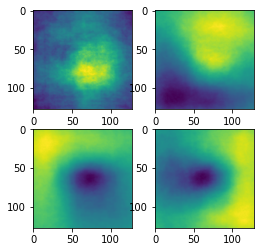

 
First 4 components for training/validation set


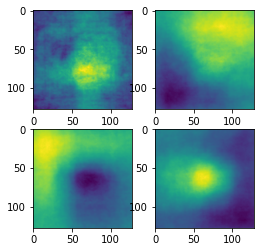

 
First 4 components for unbalanced test set


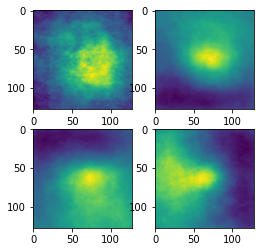

 
First 4 components for balanced set


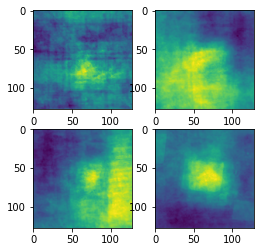

In [ ]:
print("First 4 components for entire data set")
pca = PCA(n_components = 4)
pcaMdl = pca.fit(x_entire)

plt.figure(figsize=(4,4))
for i in range(4):
    plt.subplot(2,2,i+1)
    pImg = np.array(pcaMdl.components_[i,:]).reshape(128,128)
    plt.imshow(pImg)
plt.show()
print(" ")

print("First 4 components for training/validation set")
pca = PCA(n_components = 4)
pcaMdl = pca.fit(x_tr_val)

plt.figure(figsize=(4,4))
for i in range(4):
    plt.subplot(2,2,i+1)
    pImg = np.array(pcaMdl.components_[i,:]).reshape(128,128)
    plt.imshow(pImg)
plt.show()
print(" ")

print("First 4 components for unbalanced test set")
pca = PCA(n_components = 4)
pcaMdl = pca.fit(x_unb_t)

plt.figure(figsize=(4,4))
for i in range(4):
    plt.subplot(2,2,i+1)
    pImg = np.array(pcaMdl.components_[i,:]).reshape(128,128)
    plt.imshow(pImg)
plt.show()
print(" ")

print("First 4 components for balanced set")
pca = PCA(n_components = 4)
pcaMdl = pca.fit(x_bal_t)

plt.figure(figsize=(4,4))
for i in range(4):
    plt.subplot(2,2,i+1)
    pImg = np.array(pcaMdl.components_[i,:]).reshape(128,128)
    plt.imshow(pImg)
plt.show()
print(" ")

| Subset | Variance Explained by 5 PCs | # PCs to explain at least 50% of variance |
| :-: | --- | --- |
| Training + Validation |   0.440 | 9 |
| Balanced Test |   0.455 |  8 |
| Unbalanced Test |   0.485 | 6  |
| Entire Dataset |   0.455 |  8 |

The results show the power of PCA in choosing the best features to reduce the data set. With less than 10 of the over 16,000 features, we are able to explain over 50% of the variance in the data. This suggests that it would be appropiate to use PCA later when I am actually traning multiple models. PCA will make it possible to train these models in much less time but still get results that would be decently similar to running it on the entire dataset. 

### S3:
Apply k-means clustering on the training images for 2 clusters. Calculate the "mean" image for each cluster and display it.

Q3.1: What is the accuracy on the balanced test set: ____

Q3.2: What is the accuracy on the unbalanced test set: ____

Q3.3: Show a two-by-two confusion matrix for the balanced test set (to display the number/percentage of samples in clusters 1/2 and with labels 0/1)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(x_tr_val)
y_kmeans_bal = kmeans.predict(x_bal_t)
y_kmeans_unb = kmeans.predict(x_unb_t)

acc_bal = accuracy_score(y_bal_t,y_kmeans_bal)
acc_unb = accuracy_score(y_unb_t,y_kmeans_unb)
print("accuracy for balanced test set:", acc_bal)
print("accuracy for unbalanced test set:", acc_unb)


accuracy for balanced test set: 0.4718826405867971
accuracy for unbalanced test set: 0.774390243902439


mean images:


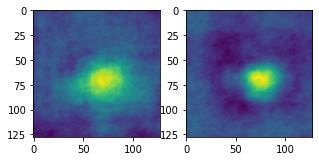

In [ ]:
means = kmeans.cluster_centers_
print("mean images:")

plt.figure(figsize=(5,14))
for i in range(2):
    plt.subplot(1,2,i+1)
    pImg = (means[i,:]).reshape(128,128)
    plt.imshow(pImg)
plt.show()


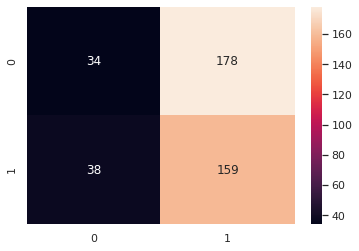

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
mat = confusion_matrix(y_bal_t, y_kmeans_bal)
ax = sns.heatmap(mat, annot=True, fmt="d")


Based off the confusion matrix, the KMeans model wrongly classified a lot of the "0 label" (no_damage) as damaged (178 of these) but it classified most of the actually damaged photos correctly (159 of 197 of these photos)

### S4:
- Train a SVM with default parameters
- Apply it on the balanced test dataset.
- Apply it on the unbalanced test set

Q4.1 Fill out the table below.

| Subset | Training Accuracy | Testing Accuracy | AUC |
| :-: | --- | --- | --- |
| Balanced Test |  |  |  |
| Unbalanced Test |  |  |  |

Q6.2: Comment on these results. Are we missing something? What other metrics should we consider?

In [ ]:
svmC = svm.SVC(probability=True)
svmC.fit(x_tr_val, y_tr_val)

y_train_pred = svmC.predict(x_tr_val)
print ('training accuracy =', accuracy_score(y_tr_val, y_train_pred))
print(" ")

y_bal_pred = svmC.predict(x_bal_t)
print ('testing accuracy balanced test =', accuracy_score(y_bal_t, y_bal_pred))
y_probas=svmC.predict_proba(x_bal_t)
probs = y_probas[:, 1]
print ('ROC balanced set AUC =', roc_auc_score(y_bal_t, probs))
print(" ")

y_unb_pred = svmC.predict(x_unb_t)
print ('testing accuracy unbalanced test =', accuracy_score(y_unb_t, y_unb_pred))
y_probas=svmC.predict_proba(x_unb_t)
probs = y_probas[:, 1]
print ('ROC balanced set AUC =', roc_auc_score(y_unb_t, probs))



training accuracy = 0.902806870548806
 
testing accuracy balanced test = 0.7652811735941321
ROC balanced set AUC = 0.834522555310794
 
testing accuracy unbalanced test = 0.7544345898004434
ROC balanced set AUC = 0.848994315369501


| Subset | Training Accuracy | Testing Accuracy | AUC |
| :-: | --- | --- | --- |
| Balanced Test |   0.903  |   0.765  |   0.834  |
| Unbalanced Test |   0.903  |   0.754 |   0.848  |


Firstly, there is a really big difference between the training accuracy and the testing accuracy which raises the alarm of overfitting. Obviously, this has been exacerbated by the fact that I am only using a small sample of the data making it more difficult to build models without overfitting. Nevertheless, it suggests that when I want to train my actual models I should pick the best models based on their cross validated scores to reduce the risk of overfitting and having a large gap between my training and testing accuracy. 

Secondly, the AUC for the unbalanced test set might be higher than that of the balanced set, but this could be artificially higher since AUC does not take the balance of the dataset into consideration. For example, I could get a speciously higher value for AUC though it could be high due to large FP, rather than the large TP (True positive). If i am looking at the unbalanced testing accuracy, I may want to consider the f-1 score instead since it takes into consideration precision and recall as well as the distribution of my data.

### S5:
- Repeat S4 using the PCA components from S2.

Q5.1 Fill out the table below.

| Subset | Training Accuracy | Testing Accuracy | AUC |
| :-: | --- | --- | --- |
| Balanced Test |  |  |  |
| Unbalanced Test |  |  |  |_

Q5.2: Compare your results with S4. What else should we consider?

In [ ]:
#model for balanced
pca = PCA(n_components= 9)
x_train_pca = pca.fit_transform(x_tr_val)
x_bal_t_pca = pca.transform(x_bal_t)
x_unb_t_pca = pca.transform(x_unb_t)
svmC.fit(x_train_pca, y_tr_val)

y_train_pred = svmC.predict(x_train_pca)
print ('training accuracy =', accuracy_score(y_tr_val, y_train_pred))
print(" ")

y_bal_pred2 = svmC.predict(x_bal_t_pca)
print ('testing accuracy balanced test =', accuracy_score(y_bal_t, y_bal_pred2))
y_probas=svmC.predict_proba(x_bal_t_pca)
probs = y_probas[:, 1]
print ('ROC balanced set AUC =', roc_auc_score(y_bal_t, probs))
print(" ")

y_unb_pred2 = svmC.predict(x_unb_t_pca)
print ('testing accuracy unbalanced test =', accuracy_score(y_unb_t, y_unb_pred2))
y_probas=svmC.predict_proba(x_unb_t_pca)
probs = y_probas[:, 1]
print ('ROC unbalanced set AUC =', roc_auc_score(y_unb_t, probs))


training accuracy = 0.7302052785923754
 
testing accuracy balanced test = 0.6577017114914425
ROC balanced set AUC = 0.7047936021453883
 
testing accuracy unbalanced test = 0.5809312638580931
ROC balanced set AUC = 0.7414723043002205



| Subset | Training Accuracy | Testing Accuracy | AUC |
| :-: | --- | --- | --- |
| Balanced Test |   0.73  |   0.658  |   0.705  |
| Unbalanced Test |   0.73  |   0.581  |   0.741  |

Again, the fact that with only 9 components I am able to get decently high training and testing accuracies and AUC demonstrates the power of PCA as an effective mechanism for dimensionality reduction and suggests that it would be beneficial to employ it when I train my models. Most of my commentary in this question would be similar to that in question 4. Again, the results show I should be careful about overfitting as well as speciously high AUCs for the unbalanced data sets testing accuracy. 
Another things I noticed this time is that the fact that the AUC is larger than the accuracy could mean that the classifier achieves the good performance on the positive class (high AUC) at the cost of a high false negatives rate (or a low number of true negative).

### S6:
- Train "your best classifier". You can use parameter optimization, different classifiers, feature dimensionality reduction, or any other processing step for feature extraction on the data.
- Add comments in your script to make it understandable to others.
- Make sure that you cross-validate your classifier properly.
- The 3 classifiers with the highest accuracy will have a bonus proportional with their rank.

Q6.1: What is the 10-fold testing accuracy of your classifier?


-----------

PREVIEW: I am going to try out a K Nearest Neighbors Classifier, a Random Forest Classifier, and a Support Vector Machine model. I will be doing parameter tuning to choose the best parameters using a Gridsearch.  I will be using nested cross validation since Model selection without nested CV uses the same data to tune model parameters and evaluate model performance which could lead to overfitting.

In [ ]:
# Initializing Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf1= KNeighborsClassifier()
clf2 = SVC(random_state=1, probability=False)
clf3 = RandomForestClassifier(random_state=1)

# Making the pipelines

pipe1 = Pipeline([('std', StandardScaler()),
                  ('clf1', clf1)])

pipe2 = Pipeline([('std', StandardScaler()),
                  ('clf2', clf2)])

# Setting up the parameter grids

param_grid1 = [{'clf1__n_neighbors': list(range(1, 6))}]

param_grid2 = [{'clf2__kernel': ['rbf'],
                'clf2__C': np.power(10., np.arange(-3, 2)),
                'clf2__gamma': np.power(10., np.arange(-4, -1))},
               {'clf2__kernel': ['linear'],
                'clf2__C': np.power(10., np.arange(-3, 2))}]

param_grid3 = [{'n_estimators': [100, 500, 1000, 10000]}]

In [ ]:
# Setting up Gridsearchcv objects
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for pgrid, est, name in zip((param_grid1, param_grid2,param_grid3),(pipe1, pipe2, clf3), ('KNN','SVM', 'RForest')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0, 
                       refit=True)
    gridcvs[name] = gcv

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 100)
x_tr_pca = pca.fit_transform(x_tr_val)

In [ ]:
for name, gs_est in sorted(gridcvs.items()):

    print(30 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    outer_scores = []
    outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    
    
    for a, b in outer_cv.split(x_tr_pca, y_tr_val):
        
        gridcvs[name].fit(x_tr_pca[a], y_tr_val[a]) # run inner loop hyperparam tuning
        print('\n        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        # perf on test fold (b)
        outer_scores.append(gridcvs[name].best_estimator_.score(x_tr_pca[b], y_tr_val[b]))
        print('        ACC (on outer test fold) %.2f%%' % (outer_scores[-1]*100))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(outer_scores) * 100, np.std(outer_scores) * 100))

------------------------------ 

Algorithm: KNN
    Inner loop:

        Best ACC (avg. of inner test folds) 57.59%
        Best parameters: {'clf1__n_neighbors': 2}
        ACC (on outer test fold) 58.58%

        Best ACC (avg. of inner test folds) 58.10%
        Best parameters: {'clf1__n_neighbors': 2}
        ACC (on outer test fold) 60.67%

        Best ACC (avg. of inner test folds) 58.56%
        Best parameters: {'clf1__n_neighbors': 2}
        ACC (on outer test fold) 55.65%

        Best ACC (avg. of inner test folds) 57.50%
        Best parameters: {'clf1__n_neighbors': 2}
        ACC (on outer test fold) 61.92%

        Best ACC (avg. of inner test folds) 57.82%
        Best parameters: {'clf1__n_neighbors': 2}
        ACC (on outer test fold) 54.39%

        Best ACC (avg. of inner test folds) 58.52%
        Best parameters: {'clf1__n_neighbors': 2}
        ACC (on outer test fold) 61.51%

        Best ACC (avg. of inner test folds) 56.19%
        Best parameters: {'clf1_

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



        Best ACC (avg. of inner test folds) 75.05%
        Best parameters: {'n_estimators': 10000}
        ACC (on outer test fold) 77.82%


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



        Best ACC (avg. of inner test folds) 74.72%
        Best parameters: {'n_estimators': 500}
        ACC (on outer test fold) 74.48%

        Best ACC (avg. of inner test folds) 74.44%
        Best parameters: {'n_estimators': 1000}
        ACC (on outer test fold) 74.90%

        Best ACC (avg. of inner test folds) 75.28%
        Best parameters: {'n_estimators': 10000}
        ACC (on outer test fold) 75.73%


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



        Best ACC (avg. of inner test folds) 75.19%
        Best parameters: {'n_estimators': 1000}
        ACC (on outer test fold) 76.99%

        Best ACC (avg. of inner test folds) 76.07%
        Best parameters: {'n_estimators': 1000}
        ACC (on outer test fold) 71.13%

        Best ACC (avg. of inner test folds) 74.91%
        Best parameters: {'n_estimators': 1000}
        ACC (on outer test fold) 72.38%

        Best ACC (avg. of inner test folds) 75.06%
        Best parameters: {'n_estimators': 1000}
        ACC (on outer test fold) 78.99%

        Best ACC (avg. of inner test folds) 75.38%
        Best parameters: {'n_estimators': 500}
        ACC (on outer test fold) 74.37%

        Best ACC (avg. of inner test folds) 76.17%
        Best parameters: {'n_estimators': 1000}
        ACC (on outer test fold) 74.79%

    Outer Loop:
        ACC 75.16% +/- 2.25
------------------------------ 

Algorithm: SVM
    Inner loop:

        Best ACC (avg. of inner test folds) 75.70%


The best classifiers are the SVM (with kernel = rbf, C=1, and gamma = 0.01) and RandomForest with 1000 estimators. 

Firstly, KNN had accuracies that were consistently lower than those of the other models so this model was easily ruled out. The overall average of the outer loop accuracies for the Random Forest and SVM models fell within one standard deviation of each other. With regards to the Random Forest Model, the models with 1000 estimators were most frequently chosen as the best in the from the gridsearch and this was the same situation for teh svm (rbf, 1, 0.01). Since their accuracies were similar (and there was a fair amount of standard deviation) I decided to use both of them to train the dataset to decide before picking one as the best model.

In [ ]:
#read in in whole data set and turn into x and y matrix

x = []
for d in image_df_tr_val['path']:
   d = cv2.imread(d)
   d = rgb2gray(d)
   x.append(d)
x = np.array(x)
x_train = x.flatten().reshape(12000,16384)
y_train = np.array(image_df_tr_val['label'])

print("entire train+val data read")


x = []
for d in image_df_test_bal['path']:
   d = cv2.imread(d)
   d = rgb2gray(d)
   x.append(d)
x = np.array(x)
x_test_balanced = x.flatten().reshape(2000,16384)
y_test_balanced = np.array(image_df_test_bal['label'])

print("entire balanced test set read")


entire train+val data read
entire balanced test set read


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 100)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.fit_transform(x_test_balanced)

In [ ]:
pca = PCA(n_components= 100)
x_train_pca = pca.fit_transform(x_train)
print("total variance ratio explained by first 100 components of entire training dataset:", np.cumsum(pca.explained_variance_ratio_)[99])
x_test_pca = pca.fit_transform(x_test_balanced)
print("total variance ratio explained by first 100 components of entire testing dataset:", np.cumsum(pca.explained_variance_ratio_)[99])

total variance ratio explained by first 100 components of entire training dataset: 0.8085686247799199
total variance ratio explained by first 100 components of entire testing dataset: 0.8272594321993975


In [ ]:
#train entire set via cross validation on best Random Forest model
rfc = RandomForestClassifier(random_state=1, n_estimators=1000)
rfc.fit(x_train_pca, y_train)
acc = cross_val_score(rfc , x_train_pca, y_train, cv = 10, scoring='accuracy')
auc = cross_val_score(rfc , x_train_pca, y_train, cv = 10, scoring='roc_auc')

print('Accuracy: %.2f%%' % (100 * np.mean(acc)))
print('ROC AUC:', np.mean(auc))

Accuracy: 76.27%
ROC AUC: 0.8573655555555556


In [ ]:
#train and test entire via cross validation set on best SVM model
svmC = svm.SVC( C=1.0, kernel='rbf', gamma=0.01, probability=True)
svmC.fit(x_train_pca, y_train)
acc = cross_val_score(svmC , x_train_pca, y_train, cv = 10, scoring='accuracy')
auc = cross_val_score(svmC , x_train_pca, y_train, cv = 10, scoring='roc_auc')

print('Accuracy: %.2f%%' % (100 * np.mean(acc)))
print('ROC AUC:', np.mean(auc))

Accuracy: 75.83%
ROC AUC: 0.8416027777777778


The Random Forest Classifier has both the higher accuracy and AUC so this is my "best model" and I will use this on my test data to evaluation its performance. 

Training both the RFC and SVM on the full dataset turned out to be a good call given that if I had just picked my best model from the gridsearch, I would probably have chosen the SVM since in one of the folds had the highest accuracy when during the cross nested parameter tuning on the sample dataset.

In [ ]:
#testing of the best cross-validated model (RandomForest) on balanced dataset

y_pred=rfc.predict(x_test_pca)
print ("best model's testing accuracy =", accuracy_score(y_test_balanced, y_pred))

y_probas=rfc.predict_proba(x_test_pca)
probs = y_probas[:, 1]
print ("best model's testing ROC AUC =", roc_auc_score(y_test_balanced, probs))


best model's testing accuracy = 0.71
best model's testing ROC AUC = 0.7741295


Explanation: As a note, I only tested on the balanced set since I was going to be using accuracy and ROC AUC as my metrics for evaluation and these do not take into consideration the distribution of the data. Even if I had also tested it on the unbalanced test set, I would have listed the metrics from the balanced test set as my final performance since these are more reliable (given reasons I have already stated earlier). The fact that my testing accuracy is pretty close to that of the cross-validated training accuracy of the whole training set as well as the nested cross validated training accuracy of the sample set shows that the cross validation really was great in avoiding overfitting and gave an appropiate depiction of the model's ability to classify the images.

Ideally, I would have liked to also create a convolutional neural network to see how the models I tried out compared to a deep learning model. Unfortunately, given how much time it took to run these models, that wasn't viable. While my current best accuracy of 71% isn't as high as I hoped, it should be noted that this is only using 100 of the 16384 possible components and using more components could possibly have given a higher accuracy. In the future, I could also expand the parameters options that I tune my model on which could provide more parameter combinations that can classify the images better.